In [ ]:
!pip install mne
!pip install pyedflib
!pip install scipy
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install pywavelets
!pip install tqdm
!pip install joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 34.2 MB/s eta 0:00:00


In [ ]:
!pip install mne pywavelets scipy -q

import os
import glob
import numpy as np
import mne
from scipy import signal
from scipy.stats import skew, kurtosis
import pywt
from google.colab import drive
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
mne.set_log_level('WARNING')

# Mount Google Drive
try:
    drive.mount('/content/drive')
    print("✅ Google Drive mounted successfully!")
except Exception as e:
    print(f"❌ Error mounting Google Drive: {e}")

SAVE_DIRECTORY = '/content/drive/MyDrive/Dream_Analysis_Project/processed_data'
os.makedirs(SAVE_DIRECTORY, exist_ok=True)

#@title Configuration Parameters
N_SUBJECTS = 5 #@param {type:"slider", min:1, max:197, step:1}
EPOCH_DURATION_S = 30
L_FREQ = 0.3
H_FREQ = 35

# EEG Frequency Bands (Hz)
BANDS = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 45)
}

print(f"Fetching data for {N_SUBJECTS} subjects...")

# Download Sleep-EDFX dataset (correct dataset)
subject_ids = list(range(N_SUBJECTS))

# Fetch data - this downloads all available recordings automatically
try:
    mne.datasets.sleep_physionet.temazepam.fetch_data(subjects=subject_ids)
    print("✅ Temazepam dataset downloaded")
except Exception as e:
    print(f"Note: {e}")
    print("Trying age dataset as fallback...")
    mne.datasets.sleep_physionet.age.fetch_data(subjects=subject_ids, recording=[1])

# Find downloaded files - search recursively in all subdirectories
mne_data_dir = os.path.join(os.path.expanduser('~'), 'mne_data', 'physionet-sleep-data')
print(f"Searching for files in: {mne_data_dir}")

# Use recursive glob to find files in subdirectories
all_files = []
for root, dirs, files in os.walk(mne_data_dir):
    for file in files:
        if file.endswith('.edf'):
            all_files.append(os.path.join(root, file))

print(f"Found {len(all_files)} total EDF files")

# Separate PSG and Hypnogram files
psg_files = sorted([f for f in all_files if 'PSG.edf' in f])
hypnogram_files = sorted([f for f in all_files if 'Hypnogram.edf' in f])

print(f"  - {len(psg_files)} PSG files")
print(f"  - {len(hypnogram_files)} Hypnogram files")

# Match pairs by finding corresponding hypnogram for each PSG
matched_pairs = []
for psg in psg_files:
    # Extract base subject ID (e.g., ST7011J from ST7011J0-PSG.edf)
    psg_basename = os.path.basename(psg)
    subject_id = psg_basename.split('-')[0][:-1]  # Remove last char and -PSG.edf

    # Find matching hypnogram
    matching_hyp = [h for h in hypnogram_files if subject_id in os.path.basename(h)]

    if matching_hyp:
        matched_pairs.append((psg, matching_hyp[0]))
        if len(matched_pairs) >= N_SUBJECTS:
            break

psg_files = [p[0] for p in matched_pairs]
hypnogram_files = [p[1] for p in matched_pairs]

if not psg_files or not hypnogram_files:
    raise FileNotFoundError("❌ Could not find downloaded EDF files.")

print(f"✅ Found {len(psg_files)} PSG files and {len(hypnogram_files)} hypnogram files.")

# Sleep stage mapping
annotation_map = {
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,  # Stage 4 merged with Stage 3 (deep sleep)
    'Sleep stage R': 4,
}

# Enhanced dream detection: REM + light sleep (where dreams can occur)
DREAM_STAGES = [4]  # Primary: REM sleep

def extract_band_power(data, sfreq, bands):
    """Extract power in different frequency bands using Welch's method"""
    features = []
    for ch_data in data:
        ch_features = []
        freqs, psd = signal.welch(ch_data, sfreq, nperseg=min(256, len(ch_data)))

        for band_name, (low, high) in bands.items():
            idx = np.logical_and(freqs >= low, freqs <= high)
            band_power = np.trapz(psd[idx], freqs[idx])
            ch_features.append(band_power)

        features.extend(ch_features)
    return np.array(features)

def extract_statistical_features(data):
    """Extract statistical features from EEG signal"""
    features = []
    for ch_data in data:
        features.extend([
            np.mean(ch_data),
            np.std(ch_data),
            np.var(ch_data),
            skew(ch_data),
            kurtosis(ch_data),
            np.percentile(ch_data, 25),
            np.percentile(ch_data, 75),
        ])
    return np.array(features)

def extract_wavelet_features(data, wavelet='db4', level=4):
    """Extract wavelet decomposition features"""
    features = []
    for ch_data in data:
        coeffs = pywt.wavedec(ch_data, wavelet, level=level)
        for coeff in coeffs:
            features.extend([
                np.mean(np.abs(coeff)),
                np.std(coeff),
                np.max(np.abs(coeff))
            ])
    return np.array(features)

def extract_connectivity_features(data):
    """Extract simple connectivity features between channels"""
    if data.shape[0] < 2:
        return np.array([0])

    # Correlation between channels
    corr_matrix = np.corrcoef(data)
    # Take upper triangle (excluding diagonal)
    triu_idx = np.triu_indices_from(corr_matrix, k=1)
    return corr_matrix[triu_idx]

# Main preprocessing loop
all_features = []
all_labels = []
all_raw_data = []  # Keep raw data for later stages

print("\n🚀 Starting enhanced preprocessing pipeline...")

for i, (psg_file, hyp_file) in enumerate(zip(psg_files, hypnogram_files)):
    print(f"  -> Processing Subject {i+1}/{N_SUBJECTS}...")

    try:
        # Load raw EEG - get ALL EEG channels
        raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)

        # Select only EEG channels (exclude EMG, EOG)
        eeg_channels = [ch for ch in raw.ch_names if 'EEG' in ch]
        raw.pick_channels(eeg_channels)

        print(f"     Using {len(eeg_channels)} EEG channels: {eeg_channels}")

        # Apply bandpass filter
        raw.filter(l_freq=L_FREQ, h_freq=H_FREQ, fir_design='firwin', verbose=False)

        # Load and apply annotations
        annotations = mne.read_annotations(hyp_file)
        raw.set_annotations(annotations, emit_warning=False)

        # Create epochs
        events, _ = mne.events_from_annotations(
            raw, event_id=annotation_map,
            chunk_duration=EPOCH_DURATION_S
        )

        epochs = mne.Epochs(
            raw=raw,
            events=events,
            tmin=0.,
            tmax=EPOCH_DURATION_S - 1/raw.info['sfreq'],
            baseline=None,
            preload=True,
            verbose=False
        )

        # Extract data and labels
        epoch_data = epochs.get_data()
        labels = epochs.events[:, -1]

        # Extract features for each epoch
        subject_features = []
        for epoch in epoch_data:
            # 1. Band power features
            band_feats = extract_band_power(epoch, raw.info['sfreq'], BANDS)

            # 2. Statistical features
            stat_feats = extract_statistical_features(epoch)

            # 3. Wavelet features
            wavelet_feats = extract_wavelet_features(epoch)

            # 4. Connectivity features
            conn_feats = extract_connectivity_features(epoch)

            # Combine all features
            combined = np.concatenate([
                band_feats,
                stat_feats,
                wavelet_feats,
                conn_feats
            ])
            subject_features.append(combined)

        subject_features = np.array(subject_features)

        # Binary labels: Dream (1) vs No Dream (0)
        binary_labels = np.isin(labels, DREAM_STAGES).astype(int)

        all_features.append(subject_features)
        all_labels.append(binary_labels)
        all_raw_data.append(epoch_data)

        print(f"     ✓ Extracted {subject_features.shape[1]} features per epoch")

    except Exception as e:
        print(f"     ✗ Error processing subject {i+1}: {e}")
        continue

print("\n✅ Preprocessing pipeline finished!")

# Consolidate data
X_features = np.concatenate(all_features, axis=0)
X_raw = np.concatenate(all_raw_data, axis=0)
y = np.concatenate(all_labels, axis=0)

print("\n--- Final Processed Data ---")
print(f"Feature matrix shape: {X_features.shape}")
print(f"  - Total Epochs: {X_features.shape[0]}")
print(f"  - Features per Epoch: {X_features.shape[1]}")
print(f"Raw data shape: {X_raw.shape}")
print(f"  - Channels: {X_raw.shape[1]}")
print(f"  - Samples per Epoch: {X_raw.shape[2]}")
print(f"Labels shape: {y.shape}")

# Class distribution
class_counts = np.bincount(y)
print("\n--- Class Distribution ---")
print(f"Class 0 (No Dream): {class_counts[0]} epochs ({100*class_counts[0]/len(y):.1f}%)")
print(f"Class 1 (Dream):    {class_counts[1]} epochs ({100*class_counts[1]/len(y):.1f}%)")

# Save both features and raw data
output_file = os.path.join(SAVE_DIRECTORY, 'stage1_preprocessed_data.npz')
np.savez_compressed(
    output_file,
    X_features=X_features,  # Engineered features for ML models
    X_raw=X_raw,           # Raw epochs for deep learning
    y=y,
    feature_names=np.array([f'feature_{i}' for i in range(X_features.shape[1])]),
    sampling_rate=raw.info['sfreq']
)

print(f"\n💾 Data saved to: {output_file}")
print("\n🎉 Enhanced preprocessing complete!")
print("\nNext steps:")
print("  1. Train Stage 1 model (Dream Detection)")
print("  2. Use predicted 'Dream' segments for Stage 2")
print("  3. Build sentiment classifier for Stage 2")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 139.3 MB/s eta 0:00:00
Mounted at /content/drive
✅ Google Drive mounted successfully!
Fetching data for 5 subjects...


✅ Temazepam dataset downloaded
Searching for files in: /root/mne_data/physionet-sleep-data
Found 10 total EDF files
  - 5 PSG files
  - 5 Hypnogram files
✅ Found 5 PSG files and 5 hypnogram files.

🚀 Starting enhanced preprocessing pipeline...
  -> Processing Subject 1/5...
     Using 2 EEG channels: ['EEG Fpz-Cz', 'EEG Pz-Oz']


/tmp/ipython-input-1804544808.py:120: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[idx], freqs[idx])


     ✓ Extracted 55 features per epoch
  -> Processing Subject 2/5...
     Using 2 EEG channels: ['EEG Fpz-Cz', 'EEG Pz-Oz']


/tmp/ipython-input-1804544808.py:120: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[idx], freqs[idx])


     ✓ Extracted 55 features per epoch
  -> Processing Subject 3/5...
     Using 2 EEG channels: ['EEG Fpz-Cz', 'EEG Pz-Oz']


/tmp/ipython-input-1804544808.py:120: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[idx], freqs[idx])


     ✓ Extracted 55 features per epoch
  -> Processing Subject 4/5...
     Using 2 EEG channels: ['EEG Fpz-Cz', 'EEG Pz-Oz']


/tmp/ipython-input-1804544808.py:120: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[idx], freqs[idx])


     ✓ Extracted 55 features per epoch
  -> Processing Subject 5/5...
     Using 2 EEG channels: ['EEG Fpz-Cz', 'EEG Pz-Oz']


/tmp/ipython-input-1804544808.py:120: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[idx], freqs[idx])


     ✓ Extracted 55 features per epoch

✅ Preprocessing pipeline finished!

--- Final Processed Data ---
Feature matrix shape: (5085, 55)
  - Total Epochs: 5085
  - Features per Epoch: 55
Raw data shape: (5085, 2, 3000)
  - Channels: 2
  - Samples per Epoch: 3000
Labels shape: (5085,)

--- Class Distribution ---
Class 0 (No Dream): 4089 epochs (80.4%)
Class 1 (Dream):    996 epochs (19.6%)

💾 Data saved to: /content/drive/MyDrive/Dream_Analysis_Project/processed_data/stage1_preprocessed_data.npz

🎉 Enhanced preprocessing complete!

Next steps:
  1. Train Stage 1 model (Dream Detection)
  2. Use predicted 'Dream' segments for Stage 2
  3. Build sentiment classifier for Stage 2


📥 Loading Stage 1 preprocessed data...
✅ Data loaded successfully!
   Features shape: (5085, 55)
   Labels shape: (5085,)
   Class distribution: [4089  996]

🔀 Splitting data (80% train, 20% test)...
✅ Split complete!
   Train set: 4068 samples
   Test set: 1017 samples
   Train distribution: [3271  797]
   Test distribution: [818 199]

📊 Scaling features...
✅ Features scaled!

⚖️ Applying SMOTE to balance classes...
✅ SMOTE applied!
   Before: [3271  797]
   After: [3271 3271]

🤖 Training models...

  -> Training Balanced Random Forest...
     ✓ Balanced Random Forest trained!

  -> Training Random Forest + SMOTE...
     ✓ Random Forest + SMOTE trained!

  -> Training Gradient Boosting...
     ✓ Gradient Boosting trained!

✅ All models trained!

📈 Model Evaluation Results


🔹 Balanced Random Forest
----------------------------------------------------------------------
Accuracy:  0.9381
Precision (Dream): 0.8063
Recall (Dream):    0.8995
F1-Score (Dream):  0.8504
ROC-AUC Score:     0.9

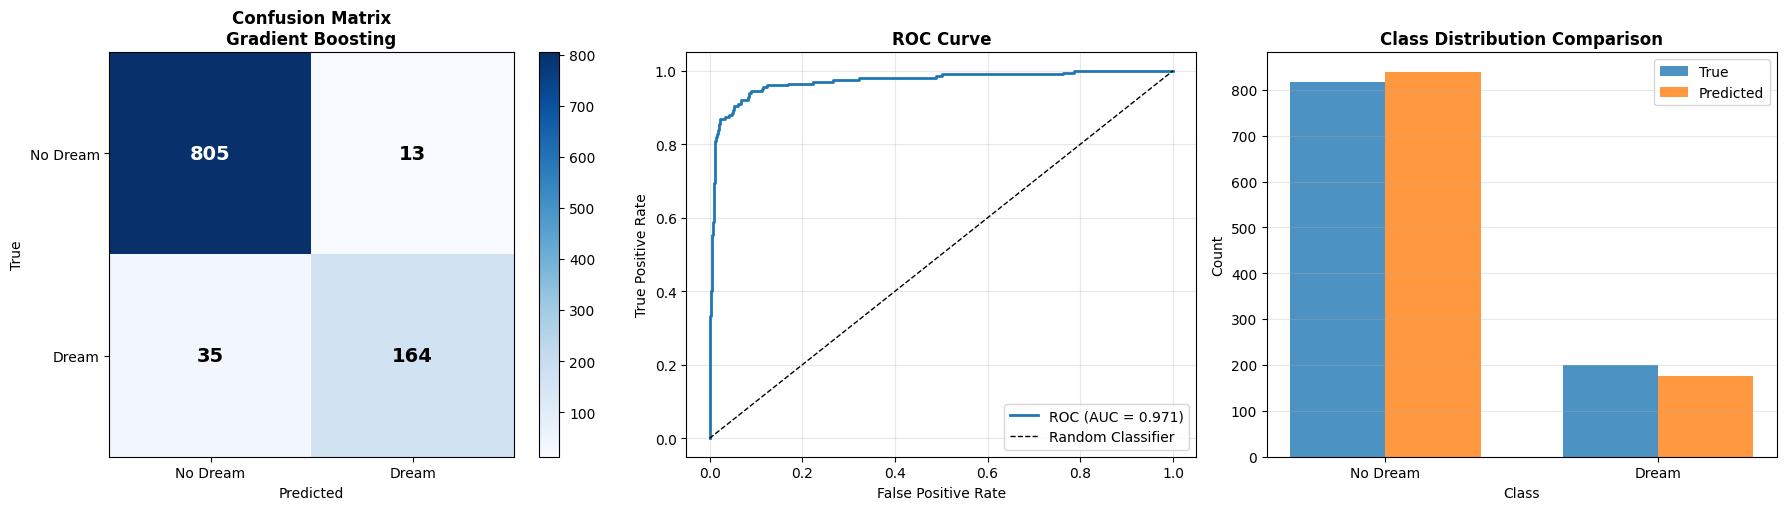

✅ Visualization saved!

💾 Saving best model and preprocessing objects...
✅ Model saved to: /content/drive/MyDrive/Dream_Analysis_Project/models/stage1_dream_detector.joblib
✅ Scaler saved to: /content/drive/MyDrive/Dream_Analysis_Project/models/stage1_scaler.joblib

🔍 Top 10 Most Important Features:
--------------------------------------------------
 1. Feature  34: 0.4826
 2. Feature   1: 0.0758
 3. Feature   4: 0.0535
 4. Feature  51: 0.0488
 5. Feature  36: 0.0362
 6. Feature  27: 0.0261
 7. Feature  37: 0.0204
 8. Feature  33: 0.0162
 9. Feature   7: 0.0140
10. Feature  20: 0.0133


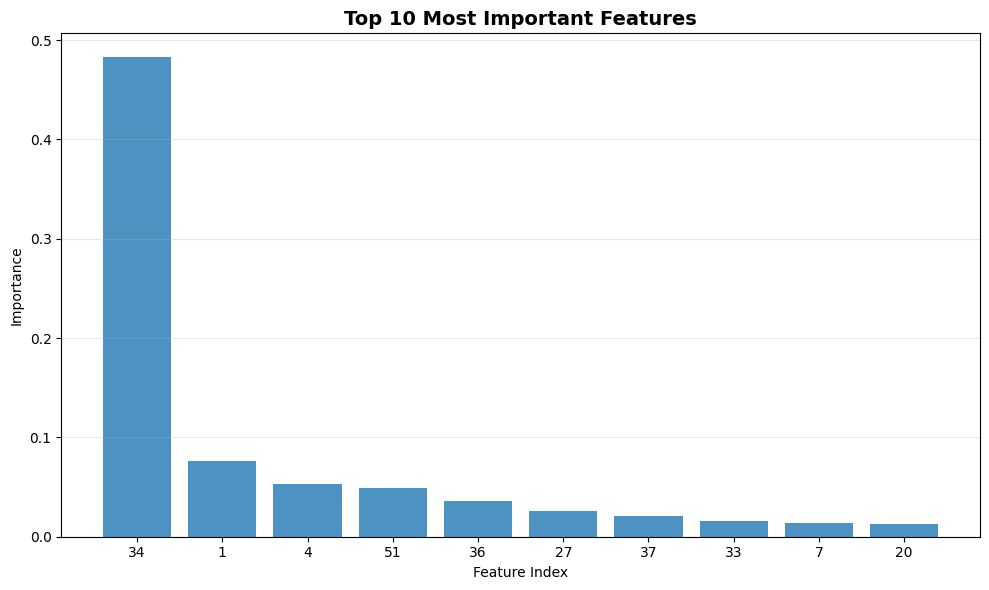


🎉 STAGE 1 MODEL TRAINING COMPLETE!

Next Steps:
  1. ✅ Stage 1 Complete - Dream Detection Model Ready
  2. ⏳ Download and preprocess DEAP dataset (Stage 2)
  3. ⏳ Train sentiment classification model (Stage 2)
  4. ⏳ Download and preprocess DREAM database (Stage 3)
  5. ⏳ Integrate all 3 stages into final pipeline


In [ ]:
!pip install imbalanced-learn scikit-learn -q

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
import joblib
import os

#@title 1. Load Preprocessed Data
print("📥 Loading Stage 1 preprocessed data...")

data_path = '/content/drive/MyDrive/Dream_Analysis_Project/processed_data/stage1_preprocessed_data.npz'
data = np.load(data_path)

X_features = data['X_features']
X_raw = data['X_raw']
y = data['y']

print(f"✅ Data loaded successfully!")
print(f"   Features shape: {X_features.shape}")
print(f"   Labels shape: {y.shape}")
print(f"   Class distribution: {np.bincount(y)}")

#@title 2. Train-Test Split with Stratification
print("\n🔀 Splitting data (80% train, 20% test)...")

X_train, X_test, y_train, y_test = train_test_split(
    X_features, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintain class distribution in both sets
)

print(f"✅ Split complete!")
print(f"   Train set: {X_train.shape[0]} samples")
print(f"   Test set: {X_test.shape[0]} samples")
print(f"   Train distribution: {np.bincount(y_train)}")
print(f"   Test distribution: {np.bincount(y_test)}")

#@title 3. Feature Scaling
print("\n📊 Scaling features...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled!")

#@title 4. Handle Class Imbalance with SMOTE
print("\n⚖️ Applying SMOTE to balance classes...")

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"✅ SMOTE applied!")
print(f"   Before: {np.bincount(y_train)}")
print(f"   After: {np.bincount(y_train_balanced)}")

#@title 5. Train Multiple Models
print("\n🤖 Training models...")

models = {
    'Balanced Random Forest': BalancedRandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        random_state=42,
        n_jobs=-1
    ),
    'Random Forest + SMOTE': RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200,
        max_depth=10,
        learning_rate=0.1,
        random_state=42
    )
}

trained_models = {}
results = {}

for name, model in models.items():
    print(f"\n  -> Training {name}...")

    if 'SMOTE' in name:
        model.fit(X_train_balanced, y_train_balanced)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    trained_models[name] = model
    results[name] = {
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"     ✓ {name} trained!")

print("\n✅ All models trained!")

#@title 6. Evaluate Models
print("\n📈 Model Evaluation Results\n")
print("="*70)

best_model_name = None
best_f1 = 0

for name, model in trained_models.items():
    y_pred = results[name]['predictions']
    y_pred_proba = results[name]['probabilities']

    print(f"\n🔹 {name}")
    print("-"*70)

    # Classification report
    report = classification_report(y_test, y_pred, target_names=['No Dream', 'Dream'], output_dict=True)

    print(f"Accuracy:  {report['accuracy']:.4f}")
    print(f"Precision (Dream): {report['Dream']['precision']:.4f}")
    print(f"Recall (Dream):    {report['Dream']['recall']:.4f}")
    print(f"F1-Score (Dream):  {report['Dream']['f1-score']:.4f}")
    print(f"ROC-AUC Score:     {roc_auc_score(y_test, y_pred_proba):.4f}")

    # Track best model
    if report['Dream']['f1-score'] > best_f1:
        best_f1 = report['Dream']['f1-score']
        best_model_name = name

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(f"  TN: {cm[0,0]:5d} | FP: {cm[0,1]:5d}")
    print(f"  FN: {cm[1,0]:5d} | TP: {cm[1,1]:5d}")

print("\n" + "="*70)
print(f"\n🏆 Best Model: {best_model_name} (F1-Score: {best_f1:.4f})")

#@title 7. Visualize Best Model Performance
best_model = trained_models[best_model_name]
y_pred_best = results[best_model_name]['predictions']
y_pred_proba_best = results[best_model_name]['probabilities']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
im = axes[0].imshow(cm, cmap='Blues')
axes[0].set_title(f'Confusion Matrix\n{best_model_name}', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(['No Dream', 'Dream'])
axes[0].set_yticklabels(['No Dream', 'Dream'])

for i in range(2):
    for j in range(2):
        axes[0].text(j, i, f'{cm[i, j]}', ha='center', va='center',
                    color='white' if cm[i, j] > cm.max()/2 else 'black',
                    fontsize=14, fontweight='bold')

plt.colorbar(im, ax=axes[0])

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)
auc_score = roc_auc_score(y_test, y_pred_proba_best)

axes[1].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {auc_score:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# 3. Class Distribution
class_counts = np.bincount(y_test)
pred_counts = np.bincount(y_pred_best)

x = np.arange(2)
width = 0.35

axes[2].bar(x - width/2, class_counts, width, label='True', alpha=0.8)
axes[2].bar(x + width/2, pred_counts, width, label='Predicted', alpha=0.8)
axes[2].set_xlabel('Class')
axes[2].set_ylabel('Count')
axes[2].set_title('Class Distribution Comparison', fontsize=12, fontweight='bold')
axes[2].set_xticks(x)
axes[2].set_xticklabels(['No Dream', 'Dream'])
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Dream_Analysis_Project/processed_data/stage1_evaluation.png', dpi=150)
plt.show()

print("✅ Visualization saved!")

#@title 8. Save Best Model and Scaler
print("\n💾 Saving best model and preprocessing objects...")

save_dir = '/content/drive/MyDrive/Dream_Analysis_Project/models'
os.makedirs(save_dir, exist_ok=True)

# Save model
model_path = os.path.join(save_dir, 'stage1_dream_detector.joblib')
joblib.dump(best_model, model_path)

# Save scaler
scaler_path = os.path.join(save_dir, 'stage1_scaler.joblib')
joblib.dump(scaler, scaler_path)

print(f"✅ Model saved to: {model_path}")
print(f"✅ Scaler saved to: {scaler_path}")

#@title 9. Feature Importance Analysis
if hasattr(best_model, 'feature_importances_'):
    print("\n🔍 Top 10 Most Important Features:")
    print("-"*50)

    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]

    for i, idx in enumerate(indices, 1):
        print(f"{i:2d}. Feature {idx:3d}: {importances[idx]:.4f}")

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(range(10), importances[indices], alpha=0.8)
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.title('Top 10 Most Important Features', fontsize=14, fontweight='bold')
    plt.xticks(range(10), indices)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Dream_Analysis_Project/processed_data/stage1_feature_importance.png', dpi=150)
    plt.show()

print("\n" + "="*70)
print("🎉 STAGE 1 MODEL TRAINING COMPLETE!")
print("="*70)
print("\nNext Steps:")
print("  1. ✅ Stage 1 Complete - Dream Detection Model Ready")
print("  2. ⏳ Download and preprocess DEAP dataset (Stage 2)")
print("  3. ⏳ Train sentiment classification model (Stage 2)")
print("  4. ⏳ Download and preprocess DREAM database (Stage 3)")
print("  5. ⏳ Integrate all 3 stages into final pipeline")

In [ ]:
# ============================================================
# 💾 SAVE BEST MODEL AND SCALER
# ============================================================

import os
import joblib

print("\n💾 Saving best model and preprocessing objects...")

save_dir = '/content/drive/MyDrive/Dream_Analysis_Project/models'
os.makedirs(save_dir, exist_ok=True)

# Save trained model
model_path = os.path.join(save_dir, 'stage1_dream_detector.joblib')
joblib.dump(best_model, model_path)

# Save feature scaler
scaler_path = os.path.join(save_dir, 'stage1_scaler.joblib')
joblib.dump(scaler, scaler_path)

print(f"✅ Model saved to: {model_path}")
print(f"✅ Scaler saved to: {scaler_path}")



💾 Saving best model and preprocessing objects...
✅ Model saved to: /content/drive/MyDrive/Dream_Analysis_Project/models/stage1_dream_detector.joblib
✅ Scaler saved to: /content/drive/MyDrive/Dream_Analysis_Project/models/stage1_scaler.joblib


TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

📥 Loading Stage 1 preprocessed data...
✅ Data loaded successfully!
   Raw data shape: (5085, 2, 3000)
   Labels shape: (5085,)
   Sampling rate: 100.0 Hz
   Class distribution: No Dream=4089, Dream=996

🔀 Preparing data for deep learning...
   Reshaped to: (5085, 3000, 2) (epochs, timesteps, channels)
✅ Data prepared!
   Train: 4068 samples
   Test: 1017 samples
   Train distribution: No Dream=3271, Dream=797

⚖️ Calculating class weights...
✅ Class weights computed:
   No Dream (0): 0.62
   Dream (1): 2.55

🏗️ Building CNN-LSTM model...
✅ Model built successfully!

📊 Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3000, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1500, 64)  │        960 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1500, 64)  │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1500, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 750, 64)   │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 750, 64)   │     12,352 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 750, 64)   │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 750, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 750, 64)   │     12,352 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 750, 64)   │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 750, 64)   │          0 │ batch_normalizat… │
│                     │                   │            │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 750, 64)   │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 750, 128)  │     24,704 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 750, 128)  │        512 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 750, 128)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 750, 128)  │     49,280 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 750, 128)  │        512 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 750, 128)  │      8,320 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 750, 128)  │          0 │ batch_normalizat

 Total params: 1,123,265 (4.28 MB)

 Trainable params: 1,120,833 (4.28 MB)

 Non-trainable params: 2,432 (9.50 KB)


⚙️ Setting up training callbacks...
✅ Callbacks configured!

🚀 Training CNN-LSTM model...

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6726 - auc: 0.7365 - loss: 0.5966 - precision: 0.3462 - recall: 0.7003
Epoch 1: val_auc improved from -inf to 0.51296, saving model to /content/drive/MyDrive/Dream_Analysis_Project/models/stage1_cnn_lstm_best.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.6732 - auc: 0.7372 - loss: 0.5960 - precision: 0.3468 - recall: 0.7009 - val_accuracy: 0.1996 - val_auc: 0.5130 - val_loss: 2.1551 - val_precision: 0.1964 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7877 - auc: 0.8631 - loss: 0.4527 - precision: 0.4681 - recall: 0.8352
Epoch 2: val_auc improved from 0.51296 to 0.64661, saving model to /content/drive/MyDrive/Dream_Analysis_Project/models/stage1_cnn_lstm_best.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - accuracy: 0.7878 - auc: 0.8633 - loss

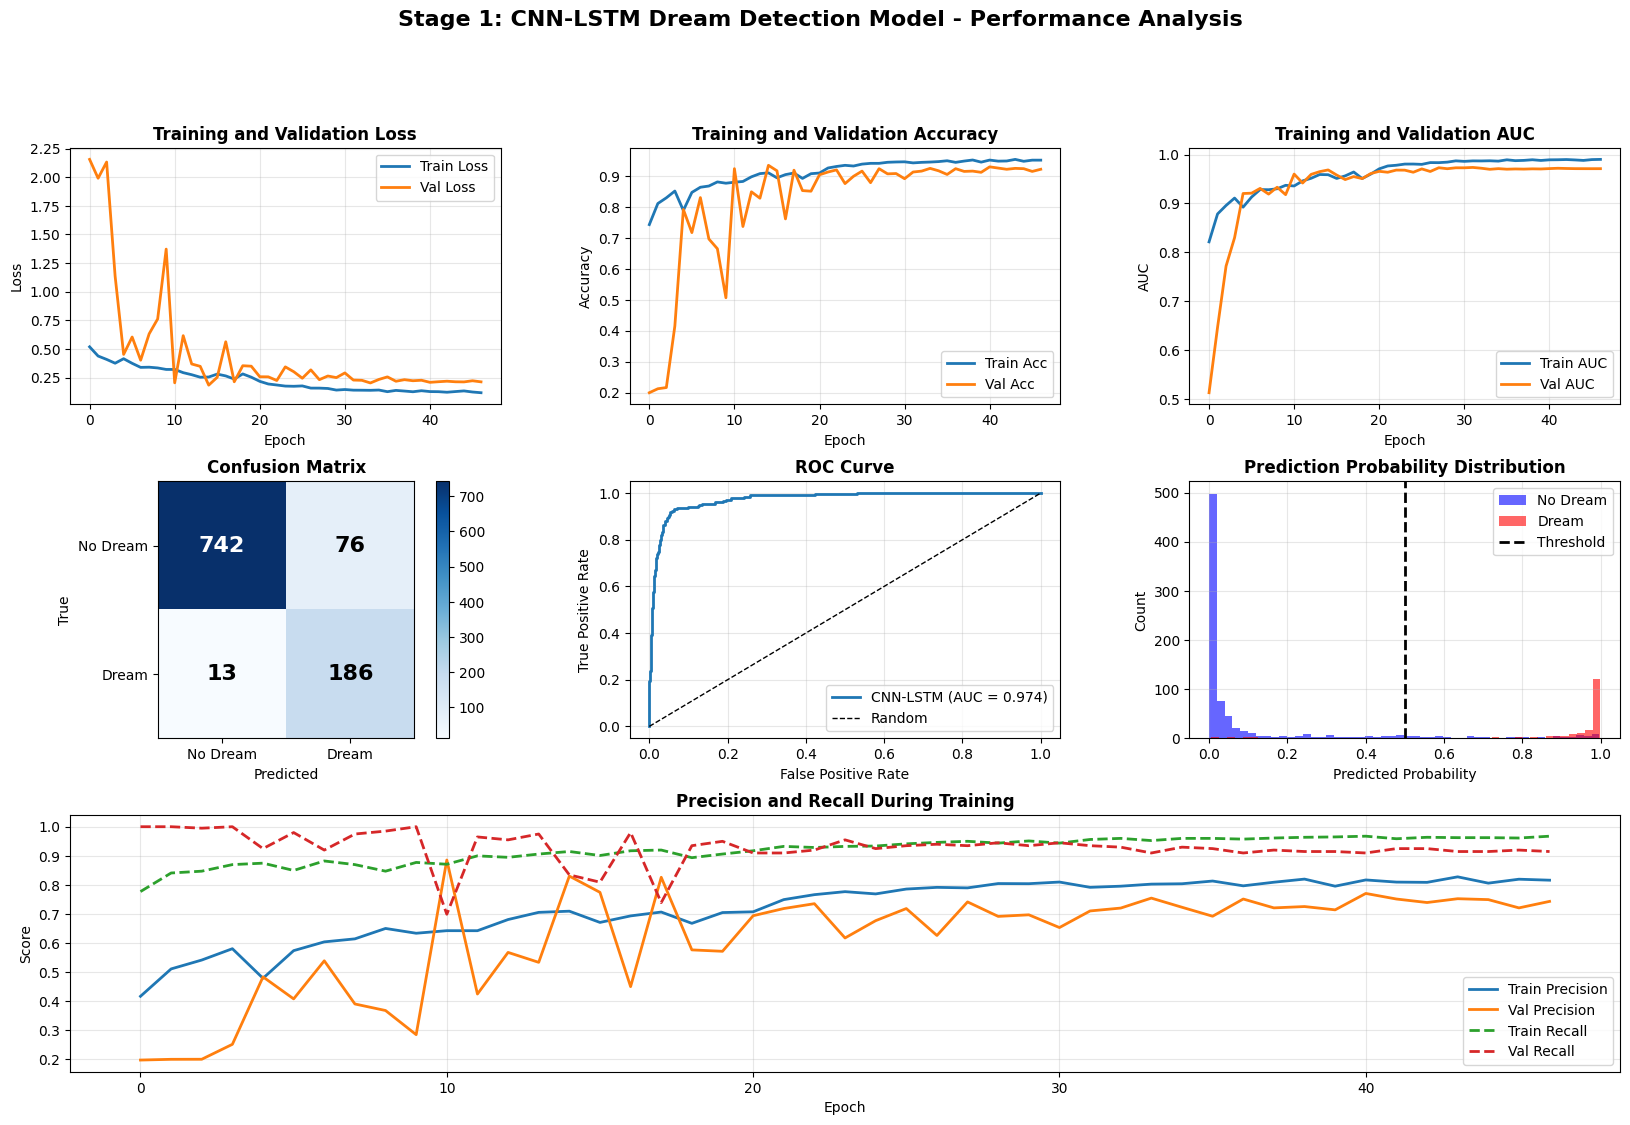

✅ Visualizations saved to: /content/drive/MyDrive/Dream_Analysis_Project/processed_data/stage1_cnn_lstm_results.png

🎉 STAGE 1 CNN-LSTM MODEL TRAINING COMPLETE!

📁 Model saved to: /content/drive/MyDrive/Dream_Analysis_Project/models/stage1_cnn_lstm_best.keras
📊 Results visualization saved

🎯 Final Performance:
   - Accuracy: 0.9213
   - AUC Score: 0.9738
   - Sensitivity: 0.9347
   - Specificity: 0.9071

📋 Next Steps:
  1. ✅ Stage 1 Complete - CNN-LSTM Dream Detection Model Ready
  2. ⏳ Download and preprocess DEAP dataset (Stage 2)
  3. ⏳ Train CNN-Transformer for sentiment (Stage 2)
  4. ⏳ Download and preprocess DREAM database (Stage 3)
  5. ⏳ Build pipeline integration script


In [ ]:
!pip install tensorflow imbalanced-learn scikit-learn -q

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
import os

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

#@title 1. Load Preprocessed Data
print("\n📥 Loading Stage 1 preprocessed data...")

data_path = '/content/drive/MyDrive/Dream_Analysis_Project/processed_data/stage1_preprocessed_data.npz'
data = np.load(data_path)

X_raw = data['X_raw']  # Shape: (n_epochs, n_channels, n_samples)
y = data['y']
sampling_rate = float(data['sampling_rate'])

print(f"✅ Data loaded successfully!")
print(f"   Raw data shape: {X_raw.shape}")
print(f"   Labels shape: {y.shape}")
print(f"   Sampling rate: {sampling_rate} Hz")
print(f"   Class distribution: No Dream={np.sum(y==0)}, Dream={np.sum(y==1)}")

#@title 2. Prepare Data for CNN-LSTM
print("\n🔀 Preparing data for deep learning...")

# Transpose to (n_epochs, n_samples, n_channels) for CNN input
# CNN expects (batch, timesteps, features)
X_reshaped = np.transpose(X_raw, (0, 2, 1))
print(f"   Reshaped to: {X_reshaped.shape} (epochs, timesteps, channels)")

# Normalize each channel independently
X_normalized = np.zeros_like(X_reshaped)
for i in range(X_reshaped.shape[2]):  # For each channel
    scaler = StandardScaler()
    X_normalized[:, :, i] = scaler.fit_transform(X_reshaped[:, :, i])

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"✅ Data prepared!")
print(f"   Train: {X_train.shape[0]} samples")
print(f"   Test: {X_test.shape[0]} samples")
print(f"   Train distribution: No Dream={np.sum(y_train==0)}, Dream={np.sum(y_train==1)}")

#@title 3. Calculate Class Weights (Handle Imbalance)
print("\n⚖️ Calculating class weights...")

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"✅ Class weights computed:")
print(f"   No Dream (0): {class_weights[0]:.2f}")
print(f"   Dream (1): {class_weights[1]:.2f}")

#@title 4. Build CNN-LSTM Model (ResNet-inspired)
print("\n🏗️ Building CNN-LSTM model...")

def build_cnn_lstm_model(input_shape):
    """
    CNN-LSTM architecture inspired by ResNet + Bi-LSTM
    - CNN layers extract spatial-temporal features
    - LSTM layers capture long-term temporal dependencies
    - Residual connections improve gradient flow
    """
    inputs = layers.Input(shape=input_shape)

    # === CNN Block 1: Feature Extraction ===
    # First convolutional layer
    x = layers.Conv1D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

    # === Residual CNN Blocks (ResNet-inspired) ===
    def residual_block(x, filters, kernel_size=3):
        shortcut = x

        # First conv
        x = layers.Conv1D(filters, kernel_size, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        # Second conv
        x = layers.Conv1D(filters, kernel_size, padding='same')(x)
        x = layers.BatchNormalization()(x)

        # Match dimensions if needed
        if shortcut.shape[-1] != filters:
            shortcut = layers.Conv1D(filters, 1, padding='same')(shortcut)

        # Add residual connection
        x = layers.Add()([x, shortcut])
        x = layers.Activation('relu')(x)
        return x

    x = residual_block(x, 64)
    x = residual_block(x, 128)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = residual_block(x, 128)
    x = residual_block(x, 256)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # === Bi-LSTM Layers: Temporal Dependencies ===
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.Dropout(0.3)(x)

    # === Dense Layers ===
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    # Output layer
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Build model
input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, channels)
model = build_cnn_lstm_model(input_shape)

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

print("✅ Model built successfully!")
print("\n📊 Model Architecture:")
model.summary()

#@title 5. Setup Callbacks
print("\n⚙️ Setting up training callbacks...")

save_dir = '/content/drive/MyDrive/Dream_Analysis_Project/models'
os.makedirs(save_dir, exist_ok=True)

checkpoint_path = os.path.join(save_dir, 'stage1_cnn_lstm_best.keras')

callbacks_list = [
    # Save best model
    callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    # Early stopping
    callbacks.EarlyStopping(
        monitor='val_auc',
        patience=15,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    # Reduce learning rate on plateau
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("✅ Callbacks configured!")

#@title 6. Train Model
print("\n🚀 Training CNN-LSTM model...\n")

EPOCHS = 100
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=callbacks_list,
    verbose=1
)

print("\n✅ Training complete!")

#@title 7. Load Best Model and Evaluate
print("\n📊 Loading best model and evaluating...")

best_model = keras.models.load_model(checkpoint_path)

# Predictions
y_pred_proba = best_model.predict(X_test, verbose=0).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

# Metrics
print("\n" + "="*70)
print("🎯 FINAL MODEL PERFORMANCE")
print("="*70)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Dream', 'Dream']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(f"  TN: {cm[0,0]:5d} | FP: {cm[0,1]:5d}")
print(f"  FN: {cm[1,0]:5d} | TP: {cm[1,1]:5d}")

# ROC-AUC
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\n🏆 ROC-AUC Score: {auc_score:.4f}")

# Sensitivity and Specificity
sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])  # True Positive Rate
specificity = cm[0,0] / (cm[0,0] + cm[0,1])  # True Negative Rate
print(f"   Sensitivity (Recall): {sensitivity:.4f}")
print(f"   Specificity: {specificity:.4f}")

#@title 8. Visualizations
print("\n📈 Generating visualizations...")

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Training Loss
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Training Accuracy
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(history.history['accuracy'], label='Train Acc', linewidth=2)
ax2.plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. AUC Score
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(history.history['auc'], label='Train AUC', linewidth=2)
ax3.plot(history.history['val_auc'], label='Val AUC', linewidth=2)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('AUC')
ax3.set_title('Training and Validation AUC', fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Confusion Matrix
ax4 = fig.add_subplot(gs[1, 0])
im = ax4.imshow(cm, cmap='Blues')
ax4.set_title('Confusion Matrix', fontweight='bold')
ax4.set_xlabel('Predicted')
ax4.set_ylabel('True')
ax4.set_xticks([0, 1])
ax4.set_yticks([0, 1])
ax4.set_xticklabels(['No Dream', 'Dream'])
ax4.set_yticklabels(['No Dream', 'Dream'])

for i in range(2):
    for j in range(2):
        ax4.text(j, i, f'{cm[i, j]}', ha='center', va='center',
                color='white' if cm[i, j] > cm.max()/2 else 'black',
                fontsize=16, fontweight='bold')
plt.colorbar(im, ax=ax4)

# 5. ROC Curve
ax5 = fig.add_subplot(gs[1, 1])
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax5.plot(fpr, tpr, linewidth=2, label=f'CNN-LSTM (AUC = {auc_score:.3f})')
ax5.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax5.set_xlabel('False Positive Rate')
ax5.set_ylabel('True Positive Rate')
ax5.set_title('ROC Curve', fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)

# 6. Prediction Distribution
ax6 = fig.add_subplot(gs[1, 2])
ax6.hist(y_pred_proba[y_test==0], bins=50, alpha=0.6, label='No Dream', color='blue')
ax6.hist(y_pred_proba[y_test==1], bins=50, alpha=0.6, label='Dream', color='red')
ax6.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
ax6.set_xlabel('Predicted Probability')
ax6.set_ylabel('Count')
ax6.set_title('Prediction Probability Distribution', fontweight='bold')
ax6.legend()
ax6.grid(alpha=0.3)

# 7. Precision-Recall
ax7 = fig.add_subplot(gs[2, :])
ax7.plot(history.history['precision'], label='Train Precision', linewidth=2)
ax7.plot(history.history['val_precision'], label='Val Precision', linewidth=2)
ax7.plot(history.history['recall'], label='Train Recall', linewidth=2, linestyle='--')
ax7.plot(history.history['val_recall'], label='Val Recall', linewidth=2, linestyle='--')
ax7.set_xlabel('Epoch')
ax7.set_ylabel('Score')
ax7.set_title('Precision and Recall During Training', fontweight='bold')
ax7.legend()
ax7.grid(alpha=0.3)

plt.suptitle('Stage 1: CNN-LSTM Dream Detection Model - Performance Analysis',
             fontsize=16, fontweight='bold', y=0.995)

save_path = '/content/drive/MyDrive/Dream_Analysis_Project/processed_data/stage1_cnn_lstm_results.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Visualizations saved to: {save_path}")

#@title 9. Summary
print("\n" + "="*70)
print("🎉 STAGE 1 CNN-LSTM MODEL TRAINING COMPLETE!")
print("="*70)
print(f"\n📁 Model saved to: {checkpoint_path}")
print(f"📊 Results visualization saved")
print(f"\n🎯 Final Performance:")
print(f"   - Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"   - AUC Score: {auc_score:.4f}")
print(f"   - Sensitivity: {sensitivity:.4f}")
print(f"   - Specificity: {specificity:.4f}")

print("\n📋 Next Steps:")
print("  1. ✅ Stage 1 Complete - CNN-LSTM Dream Detection Model Ready")
print("  2. ⏳ Download and preprocess DEAP dataset (Stage 2)")
print("  3. ⏳ Train CNN-Transformer for sentiment (Stage 2)")
print("  4. ⏳ Download and preprocess DREAM database (Stage 3)")
print("  5. ⏳ Build pipeline integration script")

In [ ]:
# ============================================================
# 🧠 SAVE FINAL TRAINED MODEL (FULL MODEL) - CNN
# ============================================================

# Path to save full model (architecture + weights)
final_model_path = '/content/drive/MyDrive/Dream_Analysis_Project/models/stage1_cnn_lstm_final.keras'

# Save the trained model
model.save(final_model_path)

print(f"✅ Final trained model saved successfully at:\n{final_model_path}")


#TO LOAD LATER
# from tensorflow.keras.models import load_model

# # Load saved model
# loaded_model = load_model('/content/drive/MyDrive/Dream_Analysis_Project/models/stage1_cnn_lstm_final.keras')

# # Check
# loaded_model.summary()

# # Predict again if needed
# y_pred_new = loaded_model.predict(X_test)



✅ Final trained model saved successfully at:
/content/drive/MyDrive/Dream_Analysis_Project/models/stage1_cnn_lstm_final.keras
